Необходимо убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем А/А-тесте, но и в целом.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
from scipy import stats


connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250120',
'user':'student',
'password':'dpo_python_2020'
}


query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-12-27' and '2025-01-02'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(query, connection=connection)

In [2]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,38,248,0.153226
1,3,10326,24,132,0.181818
2,3,123580,25,122,0.204918
3,2,131473,19,98,0.193878
4,2,23985,12,44,0.272727
...,...,...,...,...,...
16782,3,122008,20,123,0.162602
16783,2,25383,2,18,0.111111
16784,3,122190,15,56,0.267857
16785,2,108927,16,51,0.313725


In [19]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8362,8362,8362,8362
3,8425,8425,8425,8425


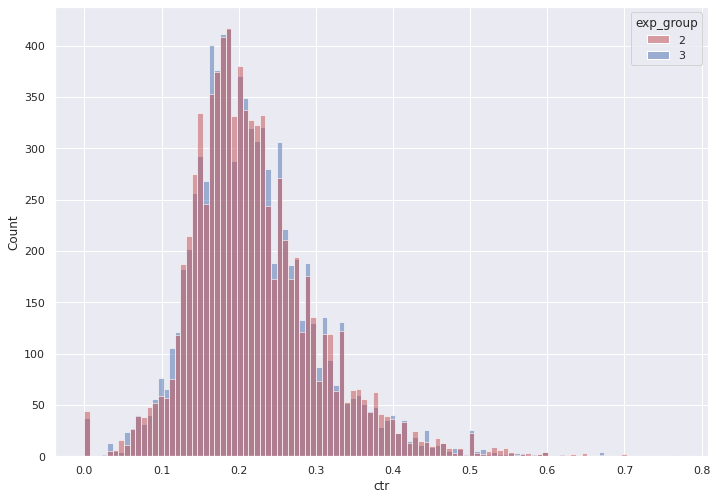

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [ ]:
#сильных визуальных различии между группами не замечено

In [22]:
#Из групп 2 и 3 берём подвыборки без возвращения размером в 500 юзеров
#Сравниваем их t-тестом и сохраняем p-value (здесь и далее используем аргумент equal_var=False)
#Повторяем это 10000 раз
count_tests = 10000
n = 500
list_ctr = []
for i in range(count_tests):
    group_1 = df[df.exp_group == 2].ctr.sample(n, replace=True)
    group_2 = df[df.exp_group == 3].ctr.sample(n, replace=True)
    p_val = stats.ttest_ind(group_1, group_2, equal_var = False)[1]
    list_ctr.append(p_val)

0.0538


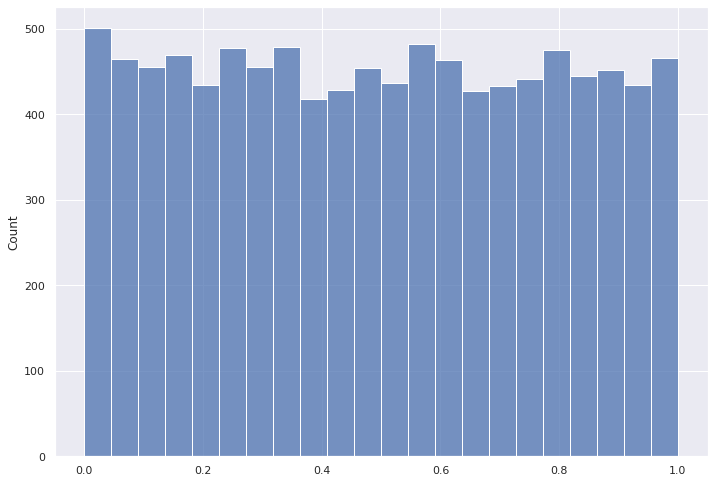

In [23]:
print(((pd.Series(list_ctr) <= 0.05).sum() / len(list_ctr)))
sns.histplot(list_ctr);

Распределение получившихся p-value является примерно 
равномерным. Значит, система сплитования работает корректно